In [25]:
%matplotlib inline

import pandas as pd
import numpy as np
from functools import reduce
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
import statsmodels.api as sm
#import mplcursors
from pylab import rcParams
from matplotlib.backends.backend_agg import FigureCanvasAgg
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

plt.style.use('seaborn-darkgrid')

In [26]:
HealthInsDF = pd.read_csv('COVID_HealthIns.csv', index_col = 0)
HealthInsDF.head()

,State,cases,deaths,Population Per State (2014),Total Health Insurance Enrollment Per State (2014),Total Health Insurance Enrollment (Percent),Medicare Enrollment Per State (2014),Medicare Enrollment (Percent),Medicaid Enrollment Per State (2014),Medicaid Enrollment (Percent),Private Enrollment Per State (2014),Private Enrollment (Percent)
0,Alabama,387786,14345,4843.0,4977.0,102.766880,947.0,19.553995,988.0,20.400578,3042.0,62.812306
1,Alaska,18316,367,737.0,611.0,82.903664,80.0,10.854817,113.0,15.332429,418.0,56.716418
2,Arizona,426614,18857,6720.0,6219.0,92.544643,1096.0,16.309524,1388.0,20.654762,3735.0,55.580357
3,Arkansas,161569,3301,2967.0,2986.0,100.640377,584.0,19.683182,812.0,27.367711,1590.0,53.589484
4,California,2664110,102387,38681.0,38951.0,100.698017,5476.0,14.156821,11505.0,29.743285,21970.0,56.797911


In [3]:
HealthInsDF.shape

(51, 12)

In [4]:
HealthInsDF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51 entries, 0 to 50
Data columns (total 12 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   State                                               51 non-null     object 
 1   cases                                               51 non-null     int64  
 2   deaths                                              51 non-null     int64  
 3   Population Per State (2014)                         51 non-null     float64
 4   Total Health Insurance Enrollment Per State (2014)  51 non-null     float64
 5   Total Health Insurance Enrollment (Percent)         51 non-null     float64
 6   Medicare Enrollment Per State (2014)                51 non-null     float64
 7   Medicare Enrollment (Percent)                       51 non-null     float64
 8   Medicaid Enrollment Per State (2014)                51 non-null     float64
 9   M

In [5]:
HealthInsDF.isnull().sum()

State                                                 0
cases                                                 0
deaths                                                0
Population Per State (2014)                           0
Total Health Insurance Enrollment Per State (2014)    0
Total Health Insurance Enrollment (Percent)           0
Medicare Enrollment Per State (2014)                  0
Medicare Enrollment (Percent)                         0
Medicaid Enrollment Per State (2014)                  0
Medicaid Enrollment (Percent)                         0
Private Enrollment Per State (2014)                   0
Private Enrollment (Percent)                          0
dtype: int64

In [6]:
HealthInsDF.count()

State                                                 51
cases                                                 51
deaths                                                51
Population Per State (2014)                           51
Total Health Insurance Enrollment Per State (2014)    51
Total Health Insurance Enrollment (Percent)           51
Medicare Enrollment Per State (2014)                  51
Medicare Enrollment (Percent)                         51
Medicaid Enrollment Per State (2014)                  51
Medicaid Enrollment (Percent)                         51
Private Enrollment Per State (2014)                   51
Private Enrollment (Percent)                          51
dtype: int64

In [7]:
HealthInsDF.describe()

,cases,deaths,Population Per State (2014),Total Health Insurance Enrollment Per State (2014),Total Health Insurance Enrollment (Percent),Medicare Enrollment Per State (2014),Medicare Enrollment (Percent),Medicaid Enrollment Per State (2014),Medicaid Enrollment (Percent),Private Enrollment Per State (2014),Private Enrollment (Percent)
count,5.100000e+01,5.100000e+01,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000
mean,1.056306e+06,5.861198e+04,6246.352941,6092.392157,98.936146,1036.235294,17.150775,1285.235294,19.523840,3770.921569,62.261531
std,2.249183e+06,1.579360e+05,7110.860212,6838.985975,6.720583,1082.000898,2.333957,1810.003355,6.031036,4031.879938,5.847677
min,1.831600e+04,2.810000e+02,584.000000,550.000000,81.740583,80.000000,10.854817,69.000000,10.061183,389.000000,47.815651
25%,1.696980e+05,4.021000e+03,1741.500000,1684.500000,93.705864,302.500000,16.028456,293.500000,15.341108,1035.500000,58.771598
50%,3.877860e+05,1.425100e+04,4413.000000,4397.000000,99.070028,755.000000,17.232739,910.000000,19.310471,2497.000000,62.952102
75%,1.047118e+06,5.046050e+04,6902.000000,7168.000000,103.080669,1197.500000,18.701774,1435.500000,23.490962,4460.000000,66.014192
max,1.504181e+07,1.081194e+06,38681.000000,38951.000000,113.353566,5476.000000,22.464313,11505.000000,36.722307,21970.000000,76.886472


In [8]:
corr = HealthInsDF.corr()
corr

,cases,deaths,Population Per State (2014),Total Health Insurance Enrollment Per State (2014),Total Health Insurance Enrollment (Percent),Medicare Enrollment Per State (2014),Medicare Enrollment (Percent),Medicaid Enrollment Per State (2014),Medicaid Enrollment (Percent),Private Enrollment Per State (2014),Private Enrollment (Percent)
cases,1.000000,0.990033,0.491439,0.518568,0.075764,0.521194,-0.088839,0.504885,0.191341,0.513086,-0.074809
deaths,0.990033,1.000000,0.399744,0.429838,0.108132,0.434067,-0.054266,0.425485,0.195058,0.421605,-0.055243
Population Per State (2014),0.491439,0.399744,1.000000,0.994317,-0.186777,0.983306,-0.215491,0.951948,0.156279,0.995356,-0.289828
Total Health Insurance Enrollment Per State (2014),0.518568,0.429838,0.994317,1.000000,-0.121462,0.983243,-0.194454,0.971279,0.190016,0.996334,-0.257955
Total Health Insurance Enrollment (Percent),0.075764,0.108132,-0.186777,-0.121462,1.000000,-0.150774,0.449643,-0.044072,0.551222,-0.145780,0.401304
Medicare Enrollment Per State (2014),0.521194,0.434067,0.983306,0.983243,-0.150774,1.000000,-0.115247,0.928093,0.165119,0.982801,-0.297579
Medicare Enrollment (Percent),-0.088839,-0.054266,-0.215491,-0.194454,0.449643,-0.115247,1.000000,-0.182323,0.213070,-0.217062,-0.102114
Medicaid Enrollment Per State (2014),0.504885,0.425485,0.951948,0.971279,-0.044072,0.928093,-0.182323,1.000000,0.297378,0.949523,-0.284583
Medicaid Enrollment (Percent),0.191341,0.195058,0.156279,0.190016,0.551222,0.165119,0.213070,0.297378,1.000000,0.144499,-0.482893
Private Enrollment Per State (2014),0.513086,0.421605,0.995356,0.996334,-0.145780,0.982801,-0.217062,0.949523,0.144499,1.000000,-0.229935


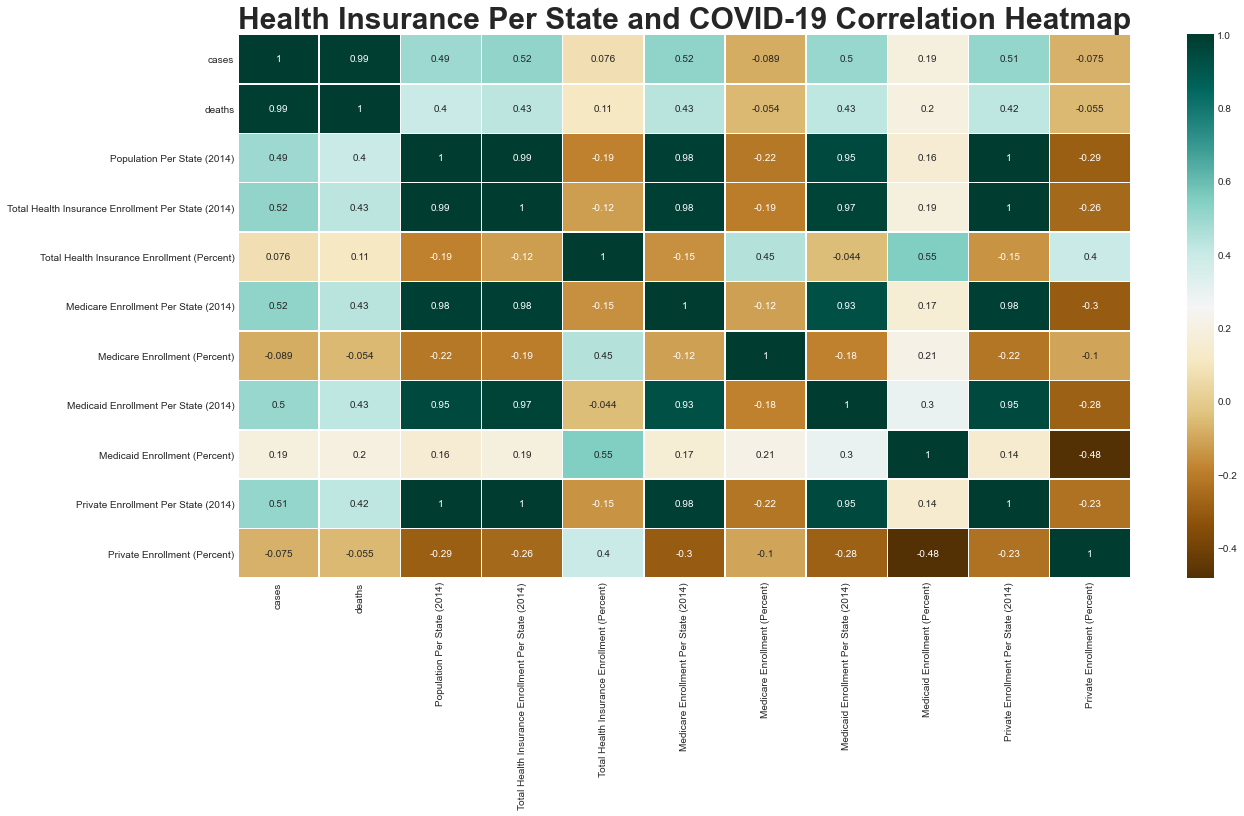

In [9]:
plt.figure(figsize = (20,10))
sns.heatmap(corr, cmap = 'BrBG', annot = True, linewidths = 0.5)
plt.title('Health Insurance Per State and COVID-19 Correlation Heatmap', fontweight = 'bold', fontsize = 30);

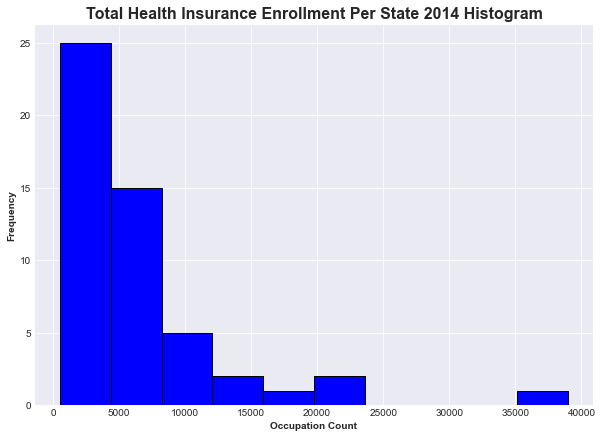

In [10]:
HealthInsDF['Total Health Insurance Enrollment Per State (2014)'].plot(kind = 'hist', color = 'blue', edgecolor = 'black', figsize = (10,7))
plt.title('Total Health Insurance Enrollment Per State 2014 Histogram', fontsize = 16, fontweight = 'bold')
plt.xlabel('Occupation Count', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold');

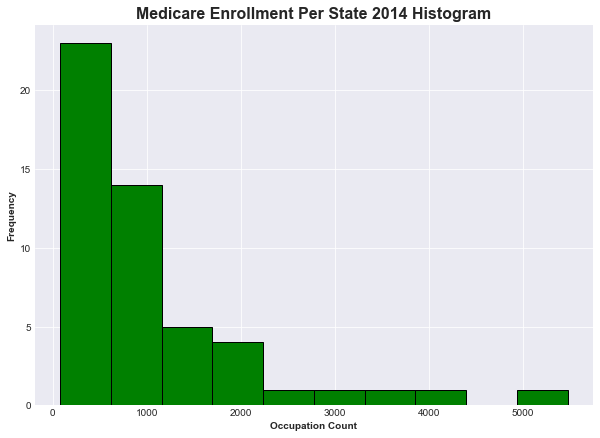

In [11]:
HealthInsDF['Medicare Enrollment Per State (2014)'].plot(kind = 'hist', color = 'green', edgecolor = 'black', figsize = (10,7))
plt.title('Medicare Enrollment Per State 2014 Histogram', fontsize = 16, fontweight = 'bold')
plt.xlabel('Occupation Count', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold');

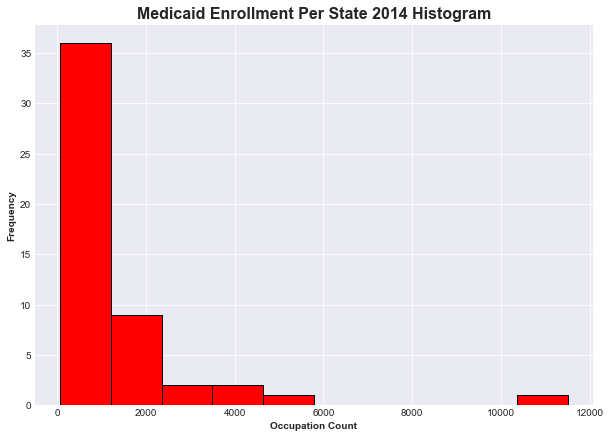

In [12]:
HealthInsDF['Medicaid Enrollment Per State (2014)'].plot(kind = 'hist', color = 'red', edgecolor = 'black', figsize = (10,7))
plt.title('Medicaid Enrollment Per State 2014 Histogram', fontsize = 16, fontweight = 'bold')
plt.xlabel('Occupation Count', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold');

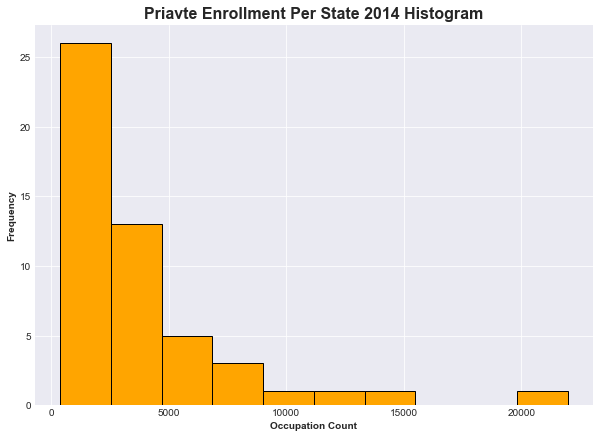

In [13]:
HealthInsDF['Private Enrollment Per State (2014)'].plot(kind = 'hist', color = 'orange', edgecolor = 'black', figsize = (10,7))
plt.title('Priavte Enrollment Per State 2014 Histogram', fontsize = 16, fontweight = 'bold')
plt.xlabel('Occupation Count', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold');

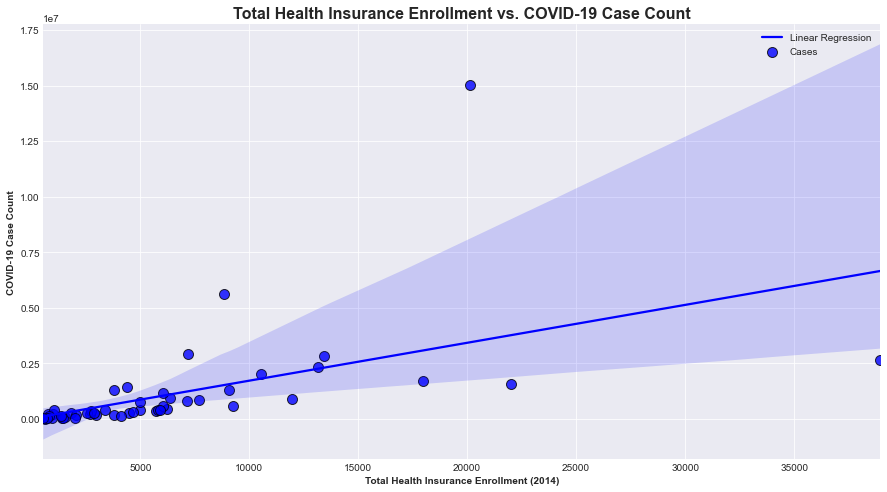

In [14]:
fig = plt.figure(figsize = (15,8))

sns.regplot(x = 'Total Health Insurance Enrollment Per State (2014)', y = 'cases', data = HealthInsDF, color = 'b', scatter_kws = {'linewidths':1, 'edgecolor':'k', 's':100})

plt.title('Total Health Insurance Enrollment vs. COVID-19 Case Count', fontsize = 16, fontweight = 'bold')
plt.xlabel('Total Health Insurance Enrollment (2014)', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Linear Regression', 'Cases'])

plt.show();

In [15]:
model1 = sm.OLS(HealthInsDF['cases'], HealthInsDF['Total Health Insurance Enrollment Per State (2014)']).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  cases   R-squared (uncentered):                   0.403
Model:                            OLS   Adj. R-squared (uncentered):              0.391
Method:                 Least Squares   F-statistic:                              33.77
Date:                Tue, 09 Jun 2020   Prob (F-statistic):                    4.29e-07
Time:                        13:54:31   Log-Likelihood:                         -809.80
No. Observations:                  51   AIC:                                      1622.
Df Residuals:                      50   BIC:                                      1624.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
======================================================================================================================
                                                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------
Total Health Insurance Enrollment Per State (2014)   171.8137     29.564      5.812      0.000     112.432     231.195
==============================================================================
Omnibus:                       83.373   Durbin-Watson:                   2.100
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1453.622
Skew:                           4.377   Prob(JB):                         0.00
Kurtosis:                      27.646   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

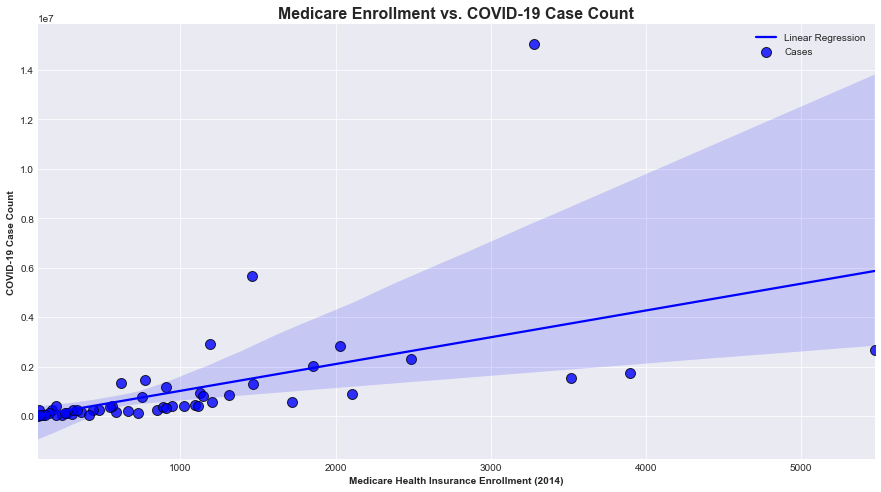

In [16]:
fig = plt.figure(figsize = (15,8))

sns.regplot(x = 'Medicare Enrollment Per State (2014)', y = 'cases', data = HealthInsDF, color = 'b', scatter_kws = {'linewidths':1, 'edgecolor':'k', 's':100})

plt.title('Medicare Enrollment vs. COVID-19 Case Count', fontsize = 16, fontweight = 'bold')
plt.xlabel('Medicare Health Insurance Enrollment (2014)', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Linear Regression', 'Cases'])

plt.show();

In [17]:
model2 = sm.OLS(HealthInsDF['cases'], HealthInsDF['Medicare Enrollment Per State (2014)']).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  cases   R-squared (uncentered):                   0.405
Model:                            OLS   Adj. R-squared (uncentered):              0.393
Method:                 Least Squares   F-statistic:                              34.04
Date:                Tue, 09 Jun 2020   Prob (F-statistic):                    3.96e-07
Time:                        13:54:31   Log-Likelihood:                         -809.72
No. Observations:                  51   AIC:                                      1621.
Df Residuals:                      50   BIC:                                      1623.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Medicare Enrollment Per State (2014)  1052.4612    180.393      5.834      0.000     690.131    1414.791
==============================================================================
Omnibus:                       85.274   Durbin-Watson:                   2.128
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1515.024
Skew:                           4.541   Prob(JB):                         0.00
Kurtosis:                      28.109   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

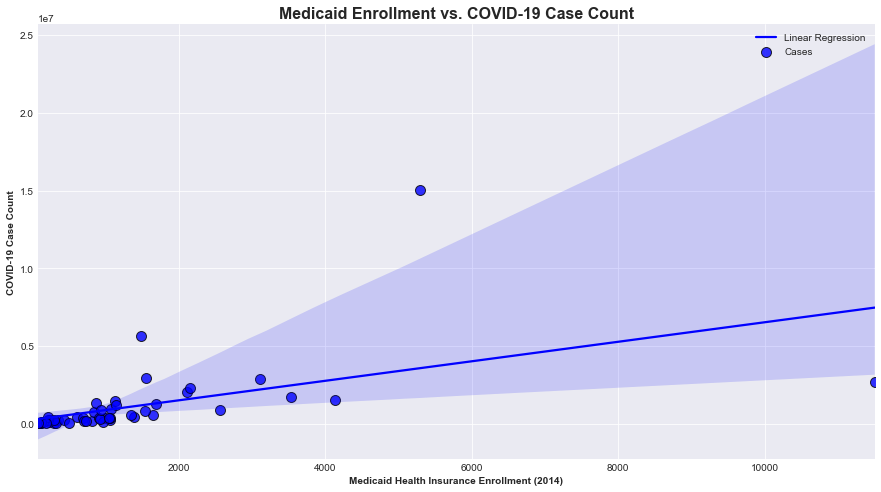

In [18]:
fig = plt.figure(figsize = (15,8))

sns.regplot(x = 'Medicaid Enrollment Per State (2014)', y = 'cases', data = HealthInsDF, color = 'b', scatter_kws = {'linewidths':1, 'edgecolor':'k', 's':100})

plt.title('Medicaid Enrollment vs. COVID-19 Case Count', fontsize = 16, fontweight = 'bold')
plt.xlabel('Medicaid Health Insurance Enrollment (2014)', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Linear Regression', 'Cases'])

plt.show();

In [19]:
model3 = sm.OLS(HealthInsDF['cases'], HealthInsDF['Medicaid Enrollment Per State (2014)']).fit()
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  cases   R-squared (uncentered):                   0.385
Model:                            OLS   Adj. R-squared (uncentered):              0.373
Method:                 Least Squares   F-statistic:                              31.30
Date:                Tue, 09 Jun 2020   Prob (F-statistic):                    9.28e-07
Time:                        13:54:31   Log-Likelihood:                         -810.57
No. Observations:                  51   AIC:                                      1623.
Df Residuals:                      50   BIC:                                      1625.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Medicaid Enrollment Per State (2014)   693.4432    123.957      5.594      0.000     444.468     942.419
==============================================================================
Omnibus:                       73.793   Durbin-Watson:                   2.084
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1084.831
Skew:                           3.652   Prob(JB):                    2.70e-236
Kurtosis:                      24.381   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

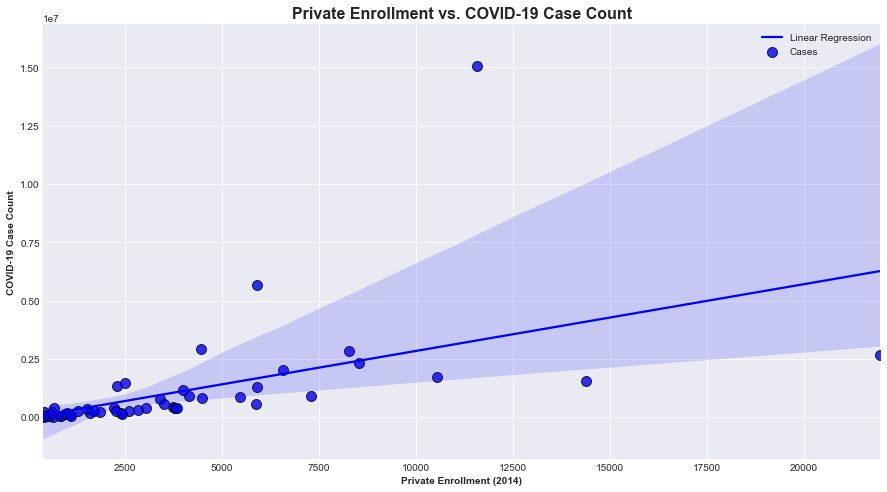

In [20]:
fig = plt.figure(figsize = (15,8))

sns.regplot(x = 'Private Enrollment Per State (2014)', y = 'cases', data = HealthInsDF, color = 'b', scatter_kws = {'linewidths':1, 'edgecolor':'k', 's':100})

plt.title('Private Enrollment vs. COVID-19 Case Count', fontsize = 16, fontweight = 'bold')
plt.xlabel('Private Enrollment (2014)', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Linear Regression', 'Cases'])

plt.show();

In [21]:
model4 = sm.OLS(HealthInsDF['cases'], HealthInsDF['Private Enrollment Per State (2014)']).fit()
model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  cases   R-squared (uncentered):                   0.399
Model:                            OLS   Adj. R-squared (uncentered):              0.386
Method:                 Least Squares   F-statistic:                              33.13
Date:                Tue, 09 Jun 2020   Prob (F-statistic):                    5.23e-07
Time:                        13:54:32   Log-Likelihood:                         -810.00
No. Observations:                  51   AIC:                                      1622.
Df Residuals:                      50   BIC:                                      1624.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Private Enrollment Per State (2014)   283.3456     49.229      5.756      0.000     184.467     382.225
==============================================================================
Omnibus:                       86.184   Durbin-Watson:                   2.094
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1608.305
Skew:                           4.589   Prob(JB):                         0.00
Kurtosis:                      28.935   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:
model5 = sm.OLS(HealthInsDF['cases'], HealthInsDF[['Total Health Insurance Enrollment Per State (2014)', 'Medicare Enrollment Per State (2014)',
                                                  'Medicaid Enrollment Per State (2014)', 'Private Enrollment Per State (2014)']]).fit()
model5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  cases   R-squared (uncentered):                   0.409
Model:                            OLS   Adj. R-squared (uncentered):              0.372
Method:                 Least Squares   F-statistic:                              11.07
Date:                Tue, 09 Jun 2020   Prob (F-statistic):                    1.22e-05
Time:                        13:54:32   Log-Likelihood:                         -809.56
No. Observations:                  51   AIC:                                      1625.
Df Residuals:                      48   BIC:                                      1631.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
======================================================================================================================
                                                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------
Total Health Insurance Enrollment Per State (2014)   310.7476    271.064      1.146      0.257    -234.263     855.758
Medicare Enrollment Per State (2014)                 790.9972   1120.337      0.706      0.484   -1461.592    3043.586
Medicaid Enrollment Per State (2014)                 -59.5817    429.321     -0.139      0.890    -922.790     803.627
Private Enrollment Per State (2014)                 -420.6678    701.497     -0.600      0.552   -1831.121     989.786
==============================================================================
Omnibus:                       81.280   Durbin-Watson:                   2.131
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1308.700
Skew:                           4.245   Prob(JB):                    6.60e-285
Kurtosis:                      26.319   Cond. No.                     4.61e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.87e-24. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

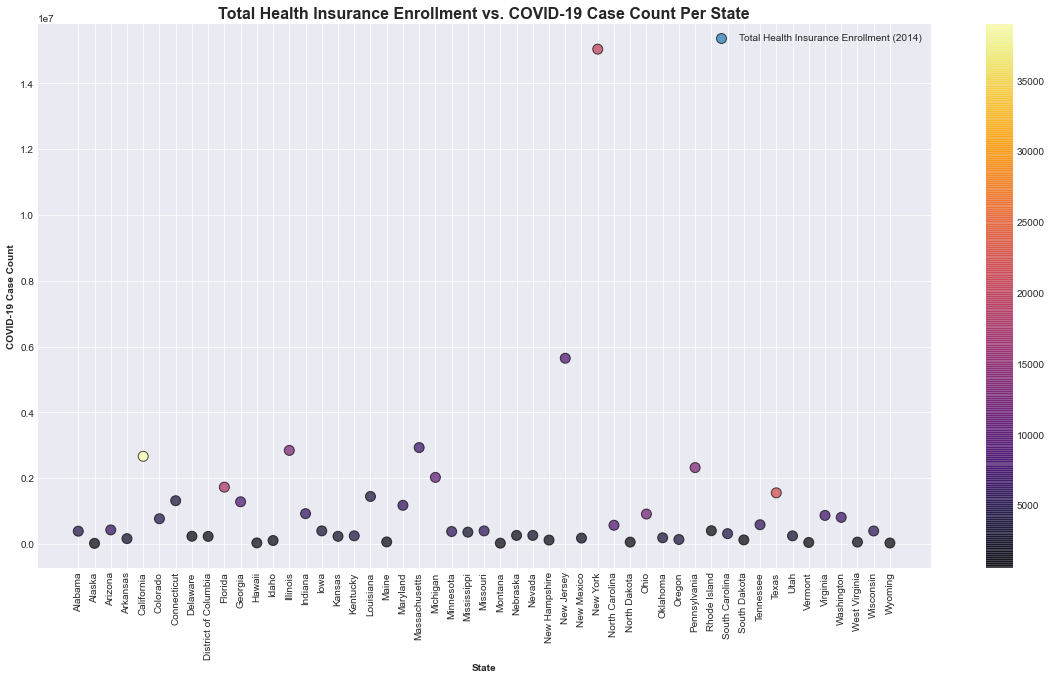

In [23]:
plt.style.use('seaborn-darkgrid')
fig = plt.figure(figsize = (20,10))

x = HealthInsDF['State'] 
y = HealthInsDF['cases']

plt.scatter(x, y, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, c = HealthInsDF['Total Health Insurance Enrollment Per State (2014)'], cmap = 'inferno')
plt.title('Total Health Insurance Enrollment vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Total Health Insurance Enrollment (2014)'])

plt.xticks(rotation = 90)

plt.colorbar()
plt.show();

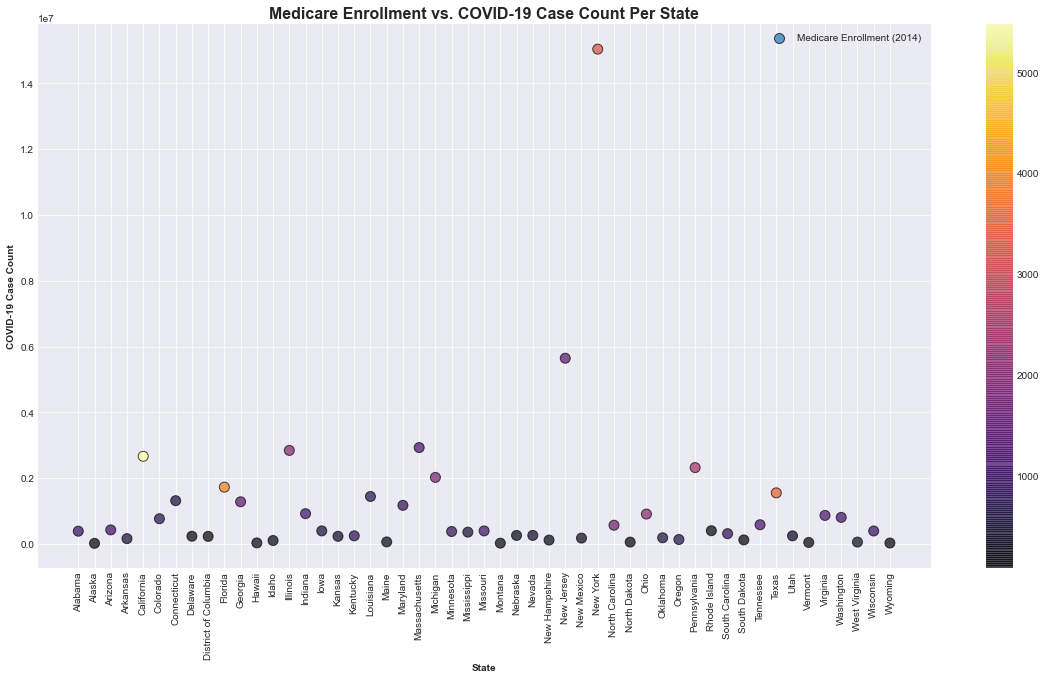

In [24]:
plt.style.use('seaborn-darkgrid')
fig = plt.figure(figsize = (20,10))

x = HealthInsDF['State'] 
y = HealthInsDF['cases']

plt.scatter(x, y, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, c = HealthInsDF['Medicare Enrollment Per State (2014)'], cmap = 'inferno')
plt.title('Medicare Enrollment vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Medicare Enrollment (2014)'])

plt.xticks(rotation = 90)

plt.colorbar()
plt.show();

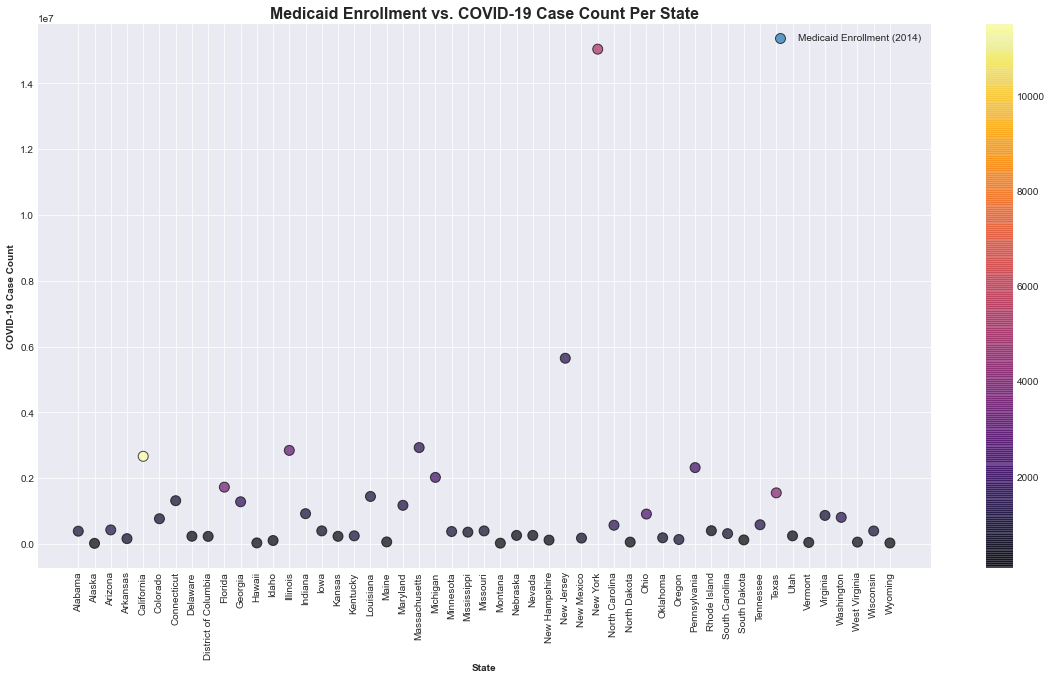

In [25]:
plt.style.use('seaborn-darkgrid')
fig = plt.figure(figsize = (20,10))

x = HealthInsDF['State'] 
y = HealthInsDF['cases']

plt.scatter(x, y, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, c = HealthInsDF['Medicaid Enrollment Per State (2014)'], cmap = 'inferno')
plt.title('Medicaid Enrollment vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Medicaid Enrollment (2014)'])

plt.xticks(rotation = 90)

plt.colorbar()
plt.show();

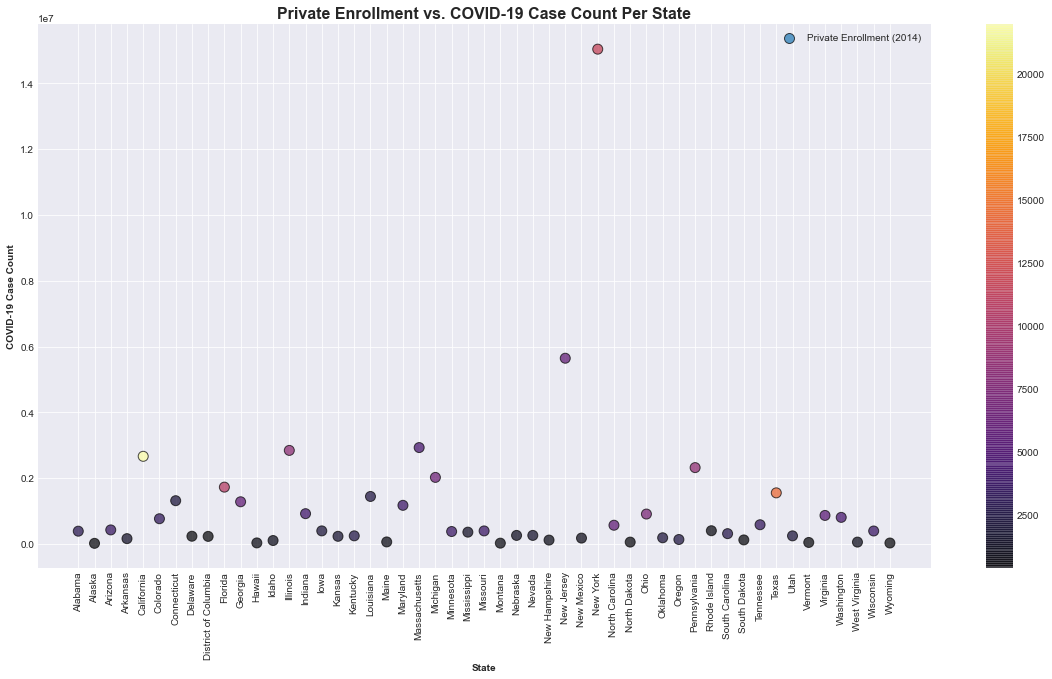

In [26]:
plt.style.use('seaborn-darkgrid')
fig = plt.figure(figsize = (20,10))

x = HealthInsDF['State'] 
y = HealthInsDF['cases']

plt.scatter(x, y, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, c = HealthInsDF['Private Enrollment Per State (2014)'], cmap = 'inferno')
plt.title('Private Enrollment vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Private Enrollment (2014)'])

plt.xticks(rotation = 90)

plt.colorbar()
plt.show();

In [27]:
test_len = int(0.25 * len(HealthInsDF))
train_len = len(HealthInsDF) - test_len
print('Train Set Len: ' + str(train_len))
print('Test Set Len: ' + str(test_len))

train = HealthInsDF[:train_len]
test = HealthInsDF[train_len:]
print('Train Set Shape: ' + str(train.shape))
print('Test Set Shape: ' + str(test.shape))

Train Set Len: 39
Test Set Len: 12
Train Set Shape: (39, 12)
Test Set Shape: (12, 12)


In [28]:
features_list = ['Total Health Insurance Enrollment Per State (2014)']
    
target = 'cases'

X_train = train[features_list]
y_train = train[target]
X_test = test[features_list]
y_test = test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(np.array(X_train).reshape(-1, 1))
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))
X_test_scaled = scaler.transform(np.array(X_test).reshape(-1, 1))

XGBmodel = XGBRegressor()
XGBmodel.fit(X_train_scaled, y_train)

train_predictions_scaled = XGBmodel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(train_predictions_scaled)
test_predictions_scaled = XGBmodel.predict(X_test_scaled)
test_predictions = scaler.inverse_transform(test_predictions_scaled)



MAE = mean_absolute_error(y_test, test_predictions)
MSE = mean_squared_error(y_test, test_predictions)
RMS = sqrt(mean_squared_error(y_test, test_predictions))
R2Score = r2_score(y_test, test_predictions)

print('MAE Value:', MAE)
print('MSE Value:', MSE)
print('RMS Value:', RMS)
print('R2 Score:', R2Score)

MAE Value: 407314406451.0833
MSE Value: 1.659050257027822e+23
RMS Value: 407314406451.3091
R2 Score: -902321842582.0109


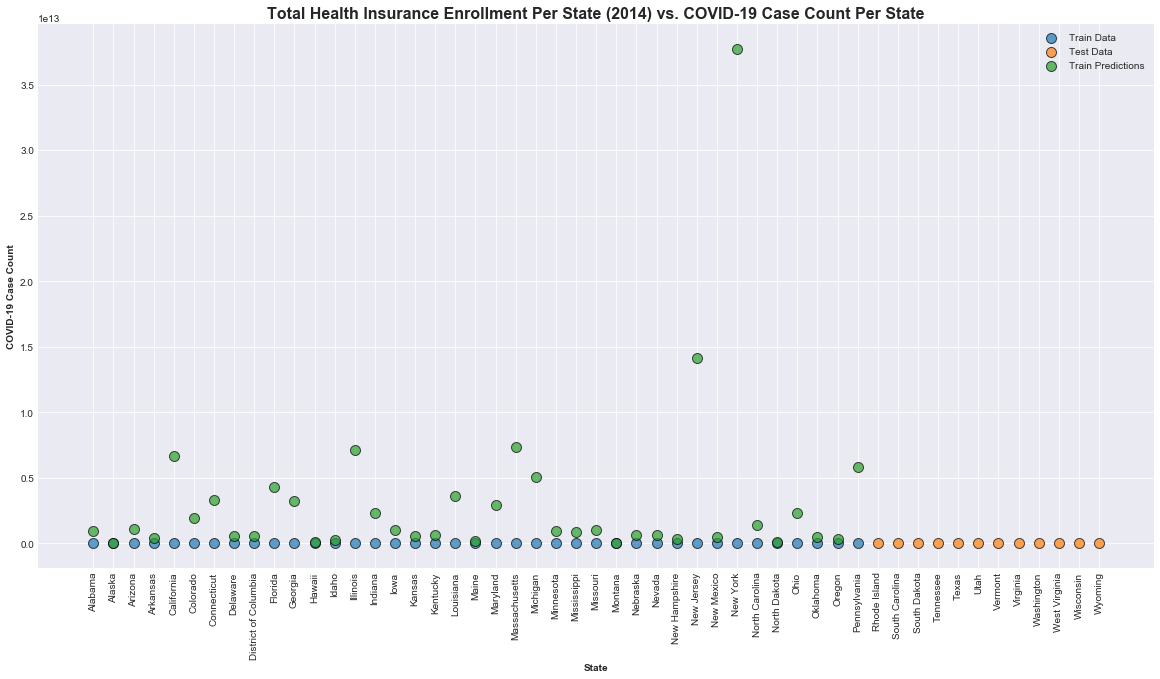

In [29]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Total Health Insurance Enrollment Per State (2014) vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();

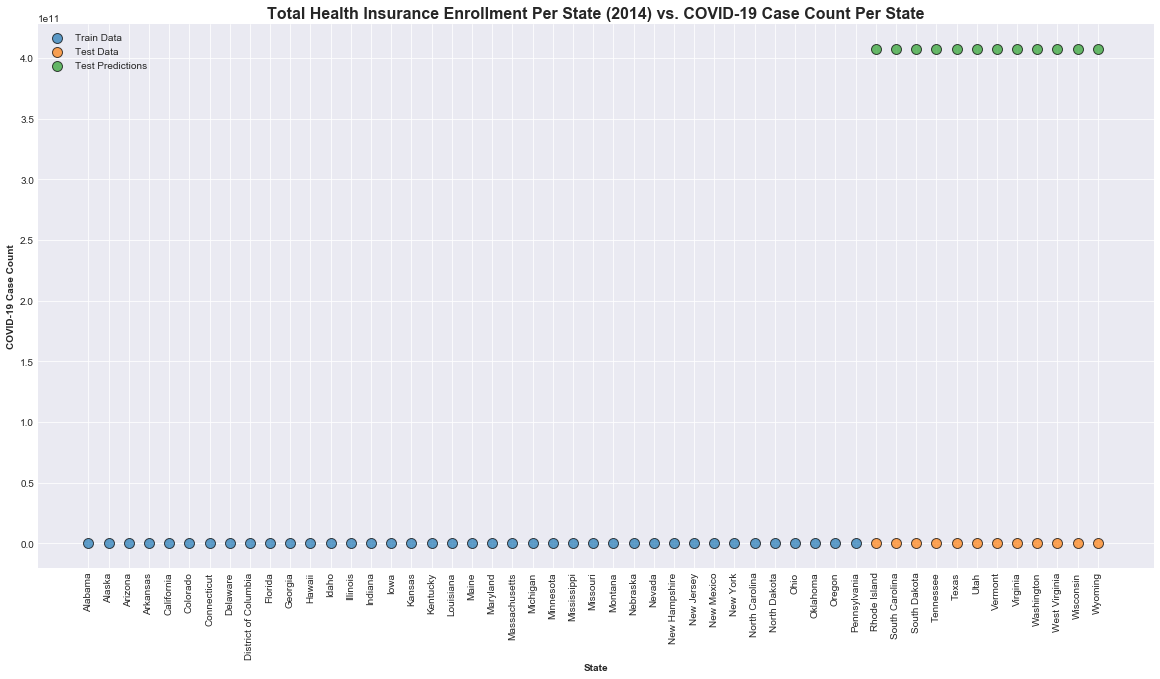

In [30]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Total Health Insurance Enrollment Per State (2014) vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [31]:
features_list = ['Medicare Enrollment Per State (2014)']
    
target = 'cases'

X_train = train[features_list]
y_train = train[target]
X_test = test[features_list]
y_test = test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(np.array(X_train).reshape(-1, 1))
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))
X_test_scaled = scaler.transform(np.array(X_test).reshape(-1, 1))

XGBmodel = XGBRegressor()
XGBmodel.fit(X_train_scaled, y_train)

train_predictions_scaled = XGBmodel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(train_predictions_scaled)
test_predictions_scaled = XGBmodel.predict(X_test_scaled)
test_predictions = scaler.inverse_transform(test_predictions_scaled)


MAE = mean_absolute_error(y_test, test_predictions)
MSE = mean_squared_error(y_test, test_predictions)
RMS = sqrt(mean_squared_error(y_test, test_predictions))
R2Score = r2_score(y_test, test_predictions)

print('MAE Value:', MAE)
print('MSE Value:', MSE)
print('RMS Value:', RMS)
print('R2 Score:', R2Score)

MAE Value: 898584091699.0834
MSE Value: 8.074533698548506e+23
RMS Value: 898584091699.1857
R2 Score: -4391565652702.8647


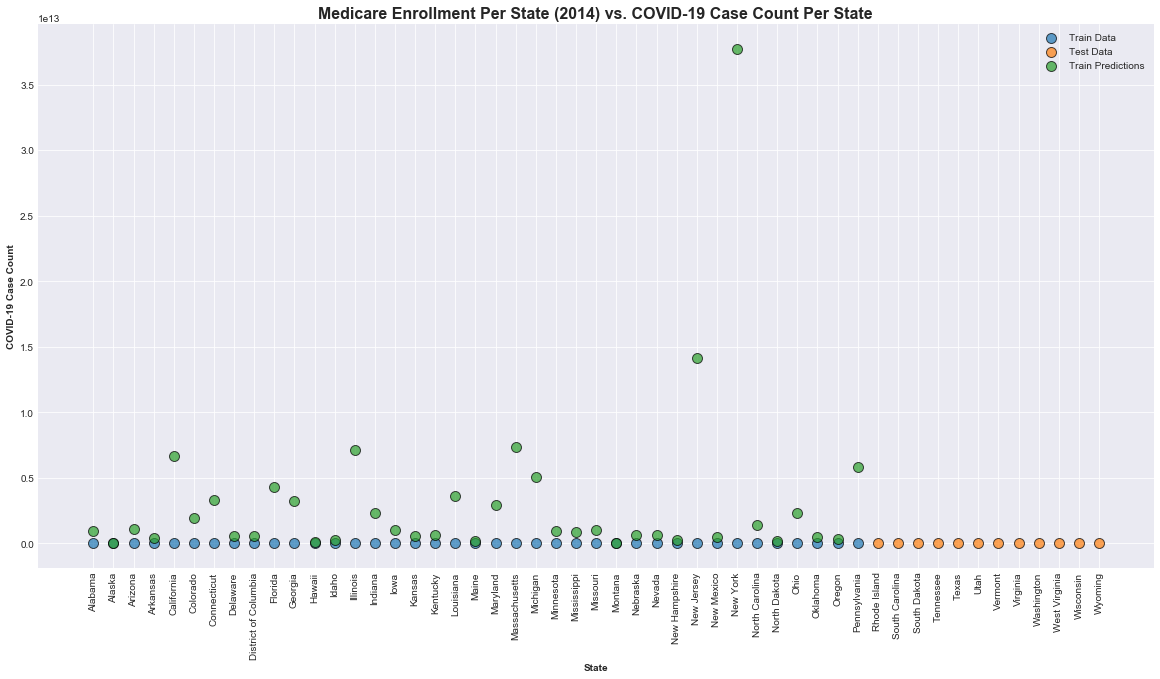

In [32]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Medicare Enrollment Per State (2014) vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();

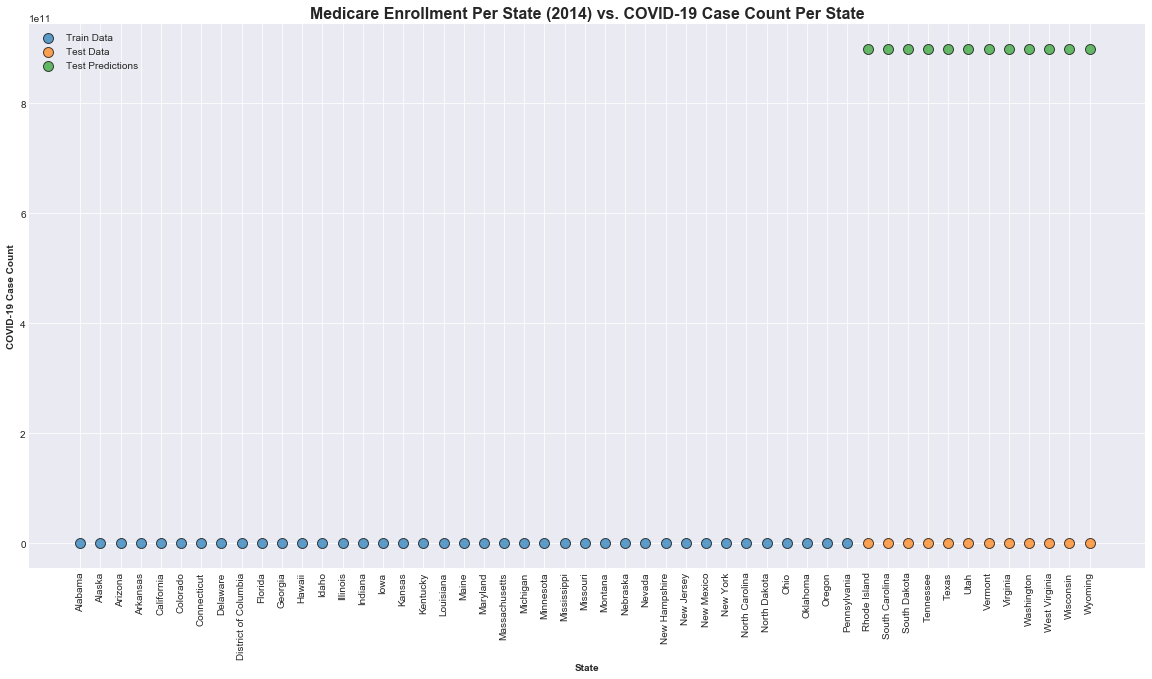

In [33]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Medicare Enrollment Per State (2014) vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [34]:
features_list = ['Medicaid Enrollment Per State (2014)']
    
target = 'cases'

X_train = train[features_list]
y_train = train[target]
X_test = test[features_list]
y_test = test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(np.array(X_train).reshape(-1, 1))
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))
X_test_scaled = scaler.transform(np.array(X_test).reshape(-1, 1))

XGBmodel = XGBRegressor()
XGBmodel.fit(X_train_scaled, y_train)

train_predictions_scaled = XGBmodel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(train_predictions_scaled)
test_predictions_scaled = XGBmodel.predict(X_test_scaled)
test_predictions = scaler.inverse_transform(test_predictions_scaled)




MAE = mean_absolute_error(y_test, test_predictions)
MSE = mean_squared_error(y_test, test_predictions)
RMS = sqrt(mean_squared_error(y_test, test_predictions))
R2Score = r2_score(y_test, test_predictions)

print('MAE Value:', MAE)
print('MSE Value:', MSE)
print('RMS Value:', RMS)
print('R2 Score:', R2Score)

MAE Value: 651222522931.0834
MSE Value: 4.240907743729092e+23
RMS Value: 651222522931.2245
R2 Score: -2306538740062.0273


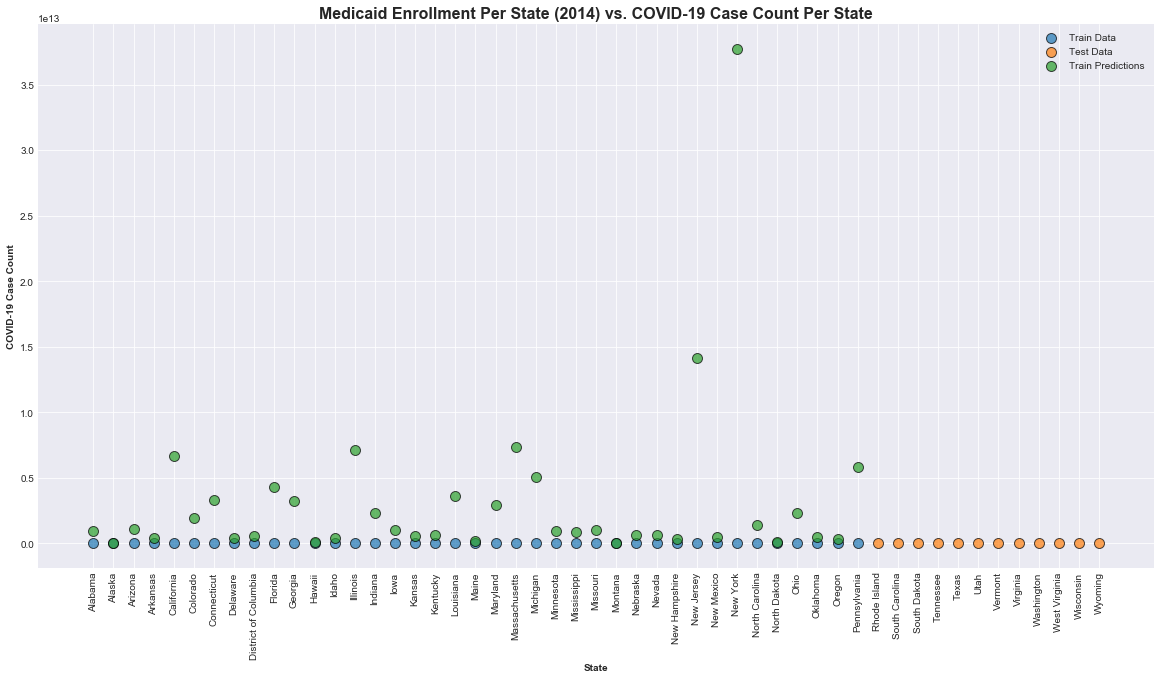

In [35]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Medicaid Enrollment Per State (2014) vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();

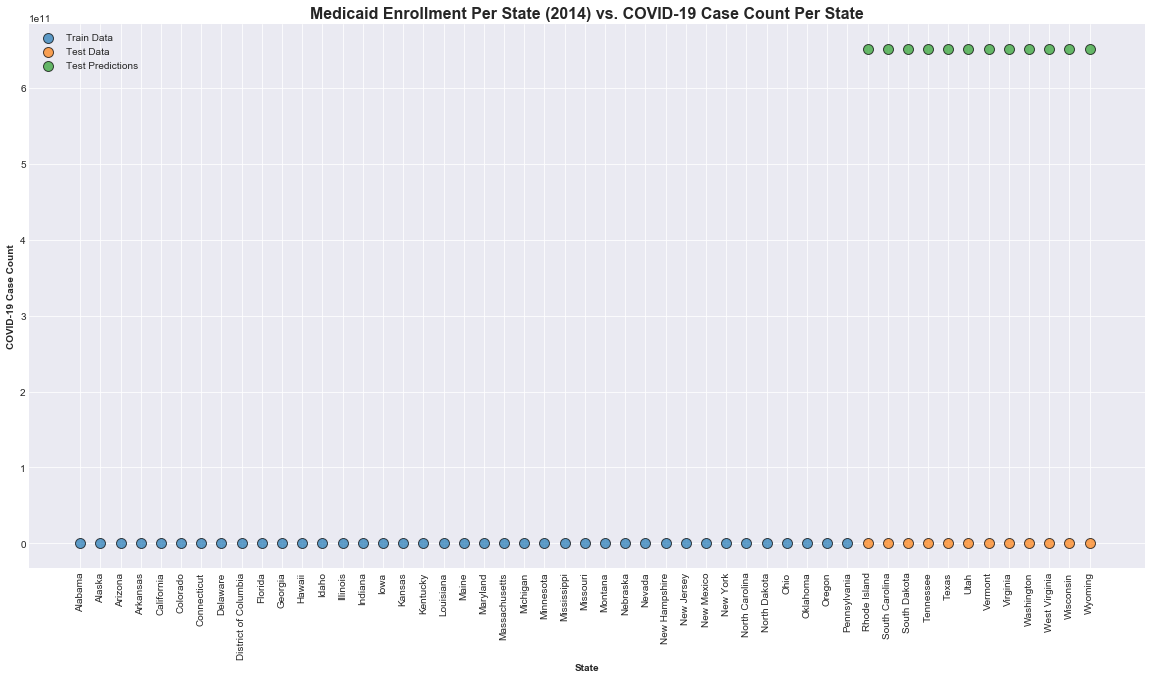

In [36]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Medicaid Enrollment Per State (2014) vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [37]:
features_list = ['Private Enrollment Per State (2014)']
    
target = 'cases'

X_train = train[features_list]
y_train = train[target]
X_test = test[features_list]
y_test = test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(np.array(X_train).reshape(-1, 1))
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))
X_test_scaled = scaler.transform(np.array(X_test).reshape(-1, 1))

XGBmodel = XGBRegressor()
XGBmodel.fit(X_train_scaled, y_train)

train_predictions_scaled = XGBmodel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(train_predictions_scaled)
test_predictions_scaled = XGBmodel.predict(X_test_scaled)
test_predictions = scaler.inverse_transform(test_predictions_scaled)

MAE = mean_absolute_error(y_test, test_predictions)
MSE = mean_squared_error(y_test, test_predictions)
RMS = sqrt(mean_squared_error(y_test, test_predictions))
R2Score = r2_score(y_test, test_predictions)

print('MAE Value:', MAE)
print('MSE Value:', MSE)
print('RMS Value:', RMS)
print('R2 Score:', R2Score)

MAE Value: 580972846131.0834
MSE Value: 3.375294479418353e+23
RMS Value: 580972846131.2416
R2 Score: -1835750255922.6567


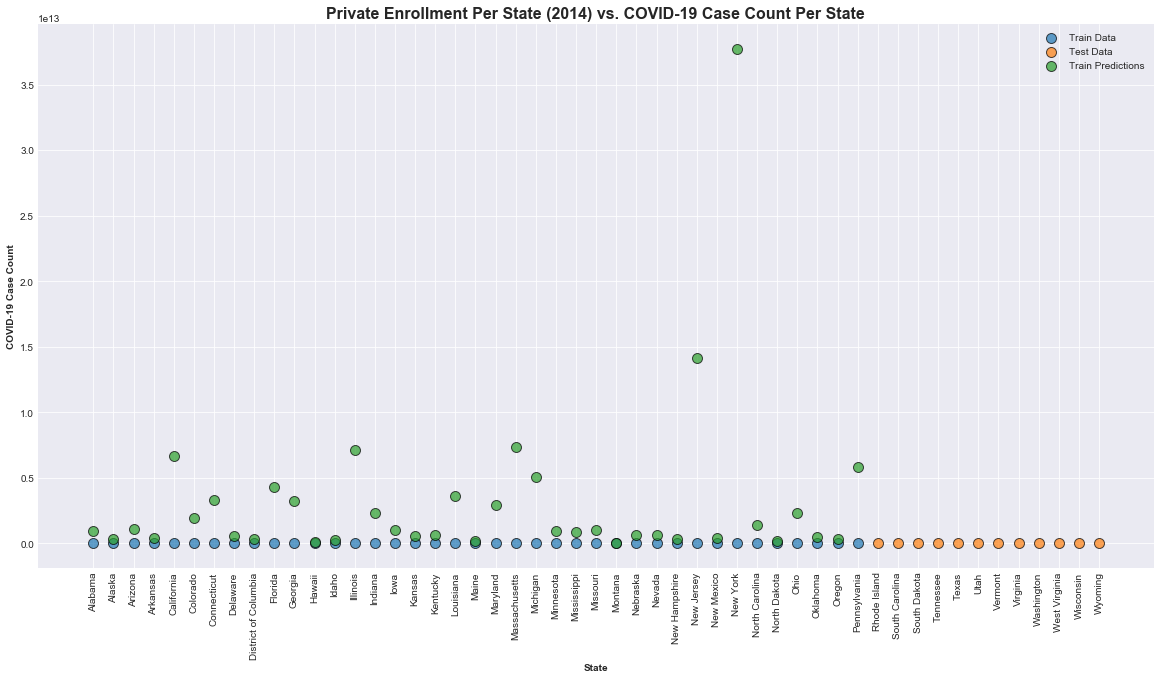

In [38]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Private Enrollment Per State (2014) vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();

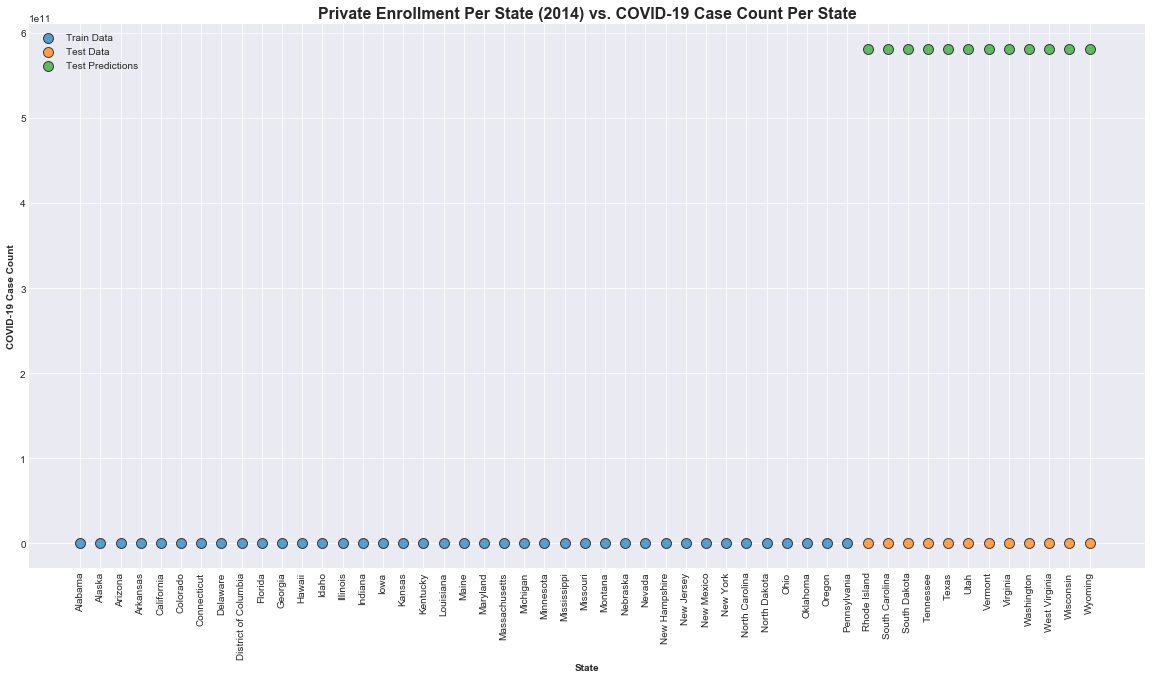

In [39]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Private Enrollment Per State (2014) vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [40]:
features_list = ['Medicaid Enrollment Per State (2014)', 'Private Enrollment Per State (2014)']
    
target = 'cases'

X_train = train[features_list]
y_train = train[target]
X_test = test[features_list]
y_test = test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform((X_train))
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))
X_test_scaled = scaler.transform(X_test)

XGBmodel = XGBRegressor()
XGBmodel.fit(X_train_scaled, y_train)

train_predictions_scaled = XGBmodel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(train_predictions_scaled)
test_predictions_scaled = XGBmodel.predict(X_test_scaled)
test_predictions = scaler.inverse_transform(test_predictions_scaled)



MAE = mean_absolute_error(y_test, test_predictions)
MSE = mean_squared_error(y_test, test_predictions)
RMS = sqrt(mean_squared_error(y_test, test_predictions))
R2Score = r2_score(y_test, test_predictions)

print('MAE Value:', MAE)
print('MSE Value:', MSE)
print('RMS Value:', RMS)
print('R2 Score:', R2Score)

MAE Value: 641561402419.0834
MSE Value: 4.1160103307412486e+23
RMS Value: 641561402419.2267
R2 Score: -2238609716608.0063


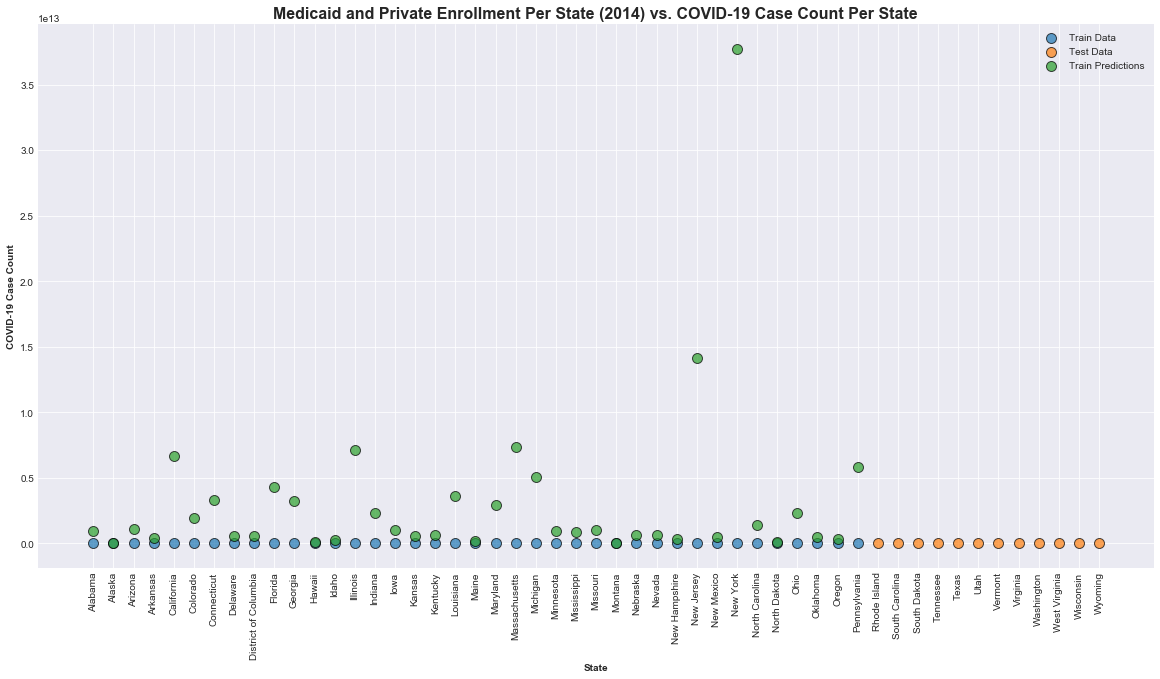

In [41]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Medicaid and Private Enrollment Per State (2014) vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();

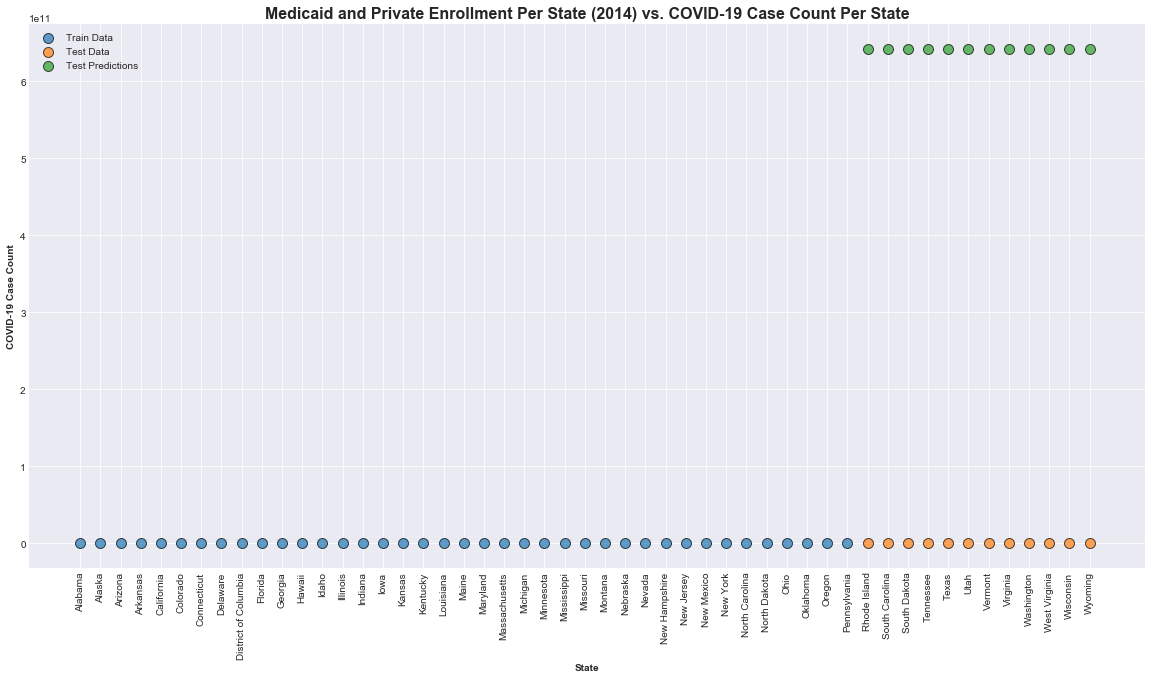

In [42]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Medicaid and Private Enrollment Per State (2014) vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [43]:
features_list = ['Medicare Enrollment Per State (2014)', 'Private Enrollment Per State (2014)']
    
target = 'cases'

X_train = train[features_list]
y_train = train[target]
X_test = test[features_list]
y_test = test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform((X_train))
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))
X_test_scaled = scaler.transform(X_test)

XGBmodel = XGBRegressor()
XGBmodel.fit(X_train_scaled, y_train)

train_predictions_scaled = XGBmodel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(train_predictions_scaled)
test_predictions_scaled = XGBmodel.predict(X_test_scaled)
test_predictions = scaler.inverse_transform(test_predictions_scaled)


MAE = mean_absolute_error(y_test, test_predictions)
MSE = mean_squared_error(y_test, test_predictions)
RMS = sqrt(mean_squared_error(y_test, test_predictions))
R2Score = r2_score(y_test, test_predictions)

print('MAE Value:', MAE)
print('MSE Value:', MSE)
print('RMS Value:', RMS)
print('R2 Score:', R2Score)

MAE Value: 800950787123.0834
MSE Value: 6.415221633932706e+23
RMS Value: 800950787123.1981
R2 Score: -3489101418589.407


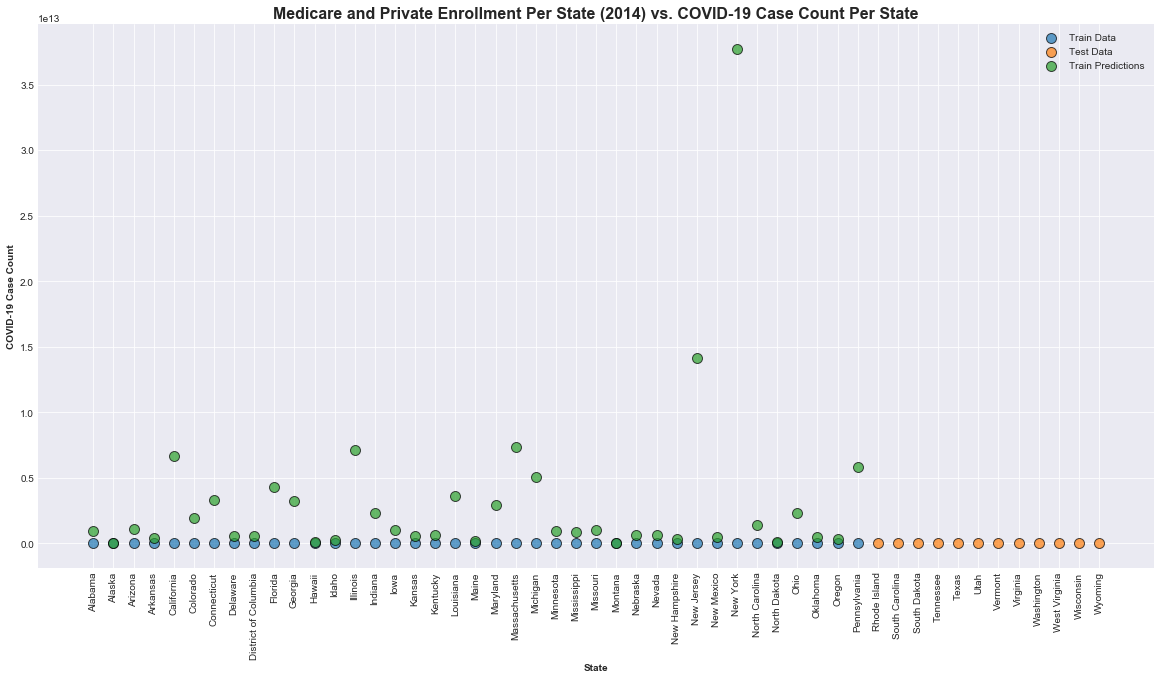

In [44]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Medicare and Private Enrollment Per State (2014) vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();

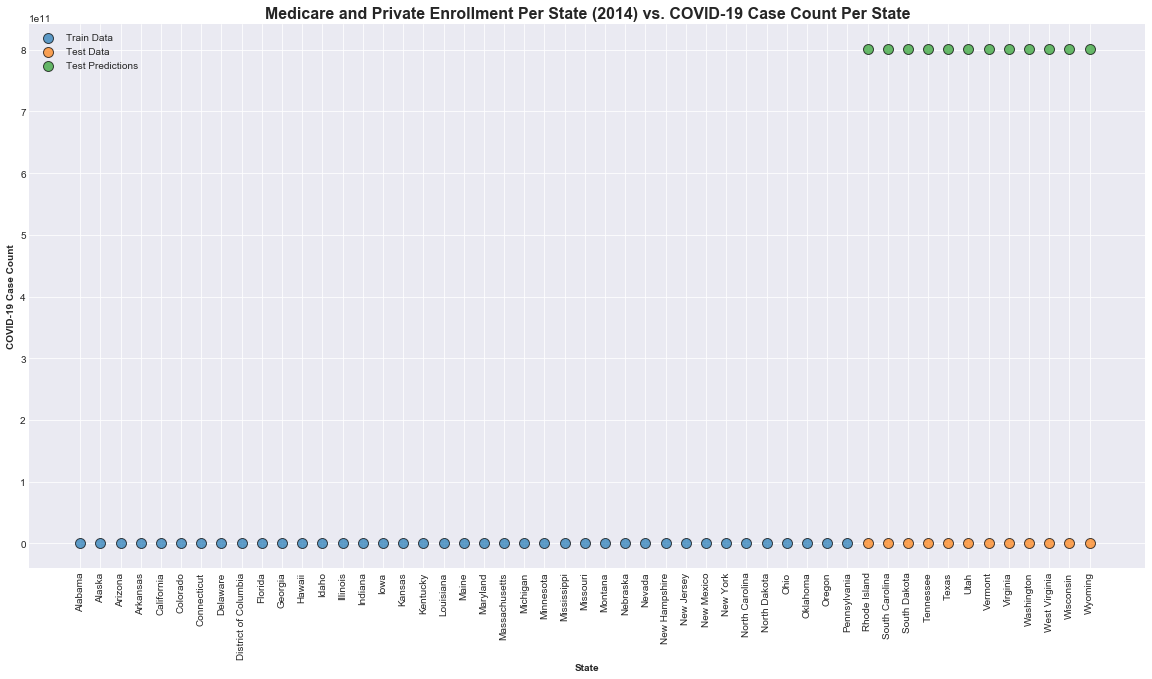

In [45]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Medicare and Private Enrollment Per State (2014) vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [47]:
features_list = ['Medicaid Enrollment Per State (2014)', 'Medicare Enrollment Per State (2014)']
    
target = 'cases'

X_train = train[features_list]
y_train = train[target]
X_test = test[features_list]
y_test = test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform((X_train))
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))
X_test_scaled = scaler.transform(X_test)

XGBmodel = XGBRegressor()
XGBmodel.fit(X_train_scaled, y_train)

train_predictions_scaled = XGBmodel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(train_predictions_scaled)
test_predictions_scaled = XGBmodel.predict(X_test_scaled)
test_predictions = scaler.inverse_transform(test_predictions_scaled)



MAE = mean_absolute_error(y_test, test_predictions)
MSE = mean_squared_error(y_test, test_predictions)
RMS = sqrt(mean_squared_error(y_test, test_predictions))
R2Score = r2_score(y_test, test_predictions)

print('MAE Value:', MAE)
print('MSE Value:', MSE)
print('RMS Value:', RMS)
print('R2 Score:', R2Score)

MAE Value: 927919053875.0834
MSE Value: 8.610337705446138e+23
RMS Value: 927919053875.1825
R2 Score: -4682977957254.362


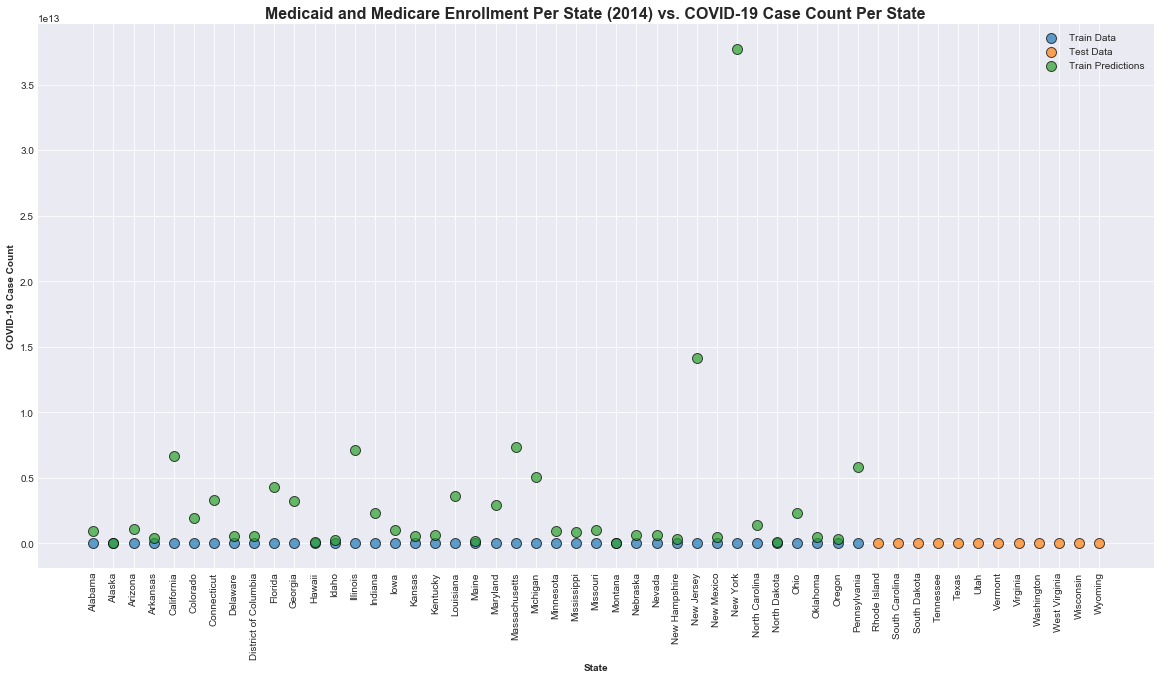

In [48]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Medicaid and Medicare Enrollment Per State (2014) vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();

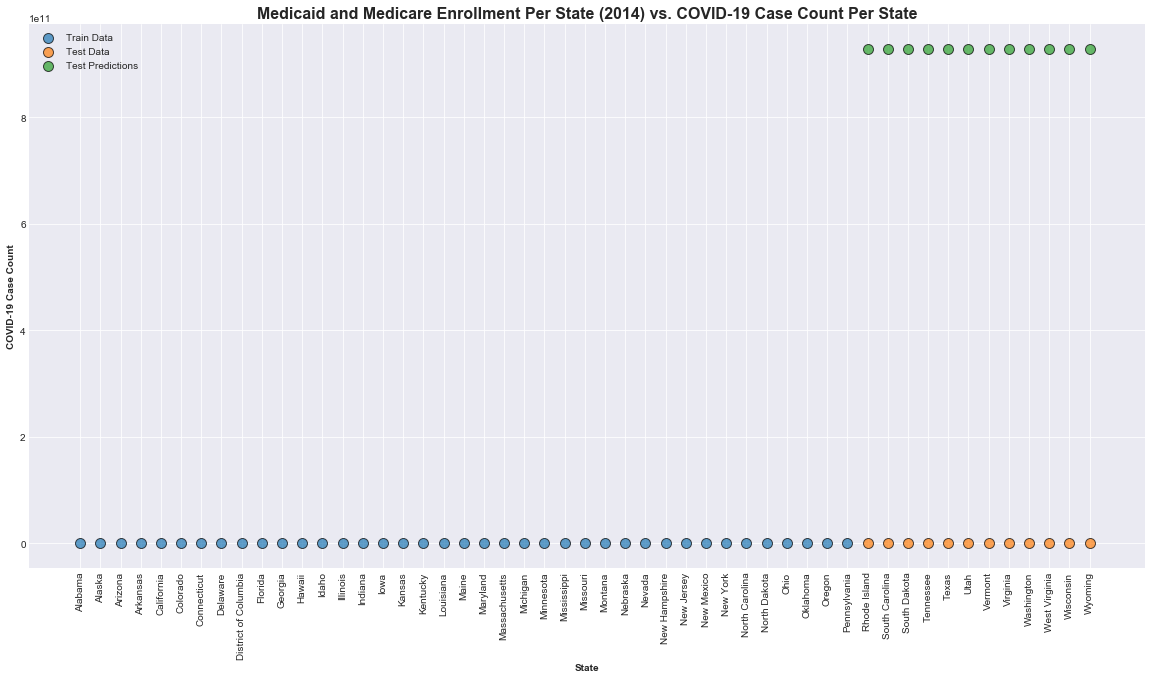

In [49]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Medicaid and Medicare Enrollment Per State (2014) vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();